In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

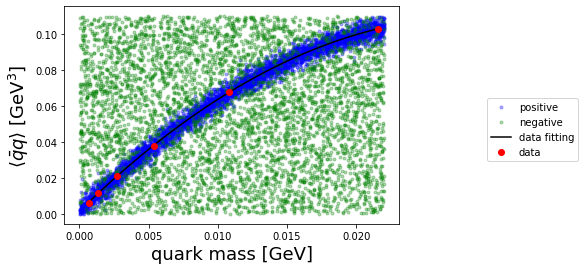

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=5000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[-1.1470982  -1.3531313   2.6616592   2.951864    5.085823    9.0305805
  7.4109755   0.05404493  5.907266    2.9462192   3.0503976   6.997921
 11.91322     7.5335255   6.205956  ]


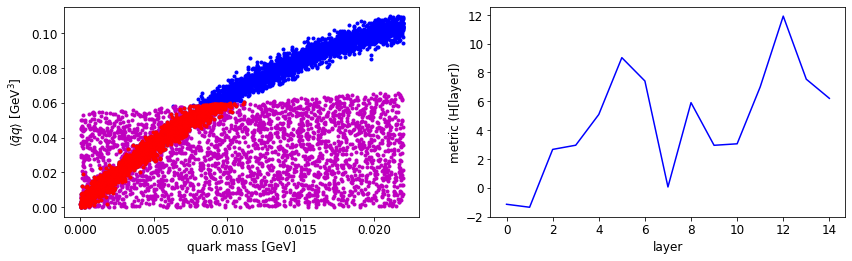

In [18]:
d = 4
m2 = -3 # mass^2
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
Test = MetricNet(Number_of_layers=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta,d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()

print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [19]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

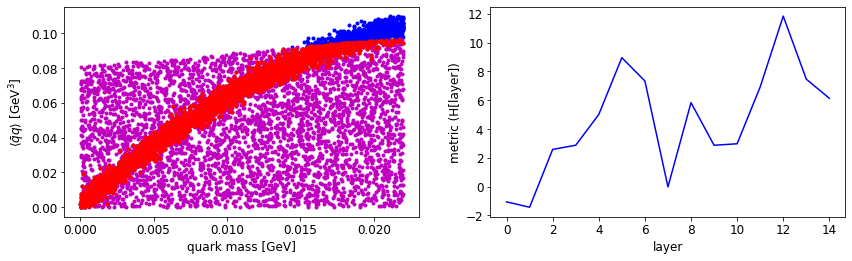

training epoch: 0,   loss: 0.5513884425163269
lambda: 0.10614456981420517,   AdS radius: 0.7172217965126038[1/GeV]
[-1.0649664  -1.4379867   2.577211    2.8678708   5.002356    8.947649
  7.328478   -0.02810599  5.8255777   2.864927    2.9695234   6.917486
 11.833159    7.4537015   6.1263137 ]


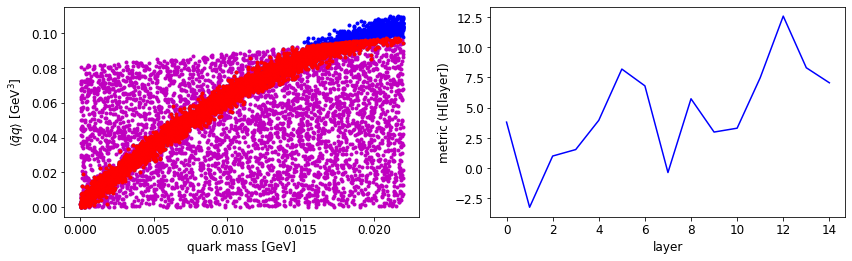

training epoch: 100,   loss: 0.22778424620628357
lambda: -4.138030052185059,   AdS radius: 0.7273372411727905[1/GeV]
[ 3.8069942  -3.2240438   1.0060358   1.5410328   3.956877    8.189033
  6.8046856  -0.35608736  5.735591    2.9869018   3.3063154   7.4706664
 12.564036    8.299271    7.0567746 ]


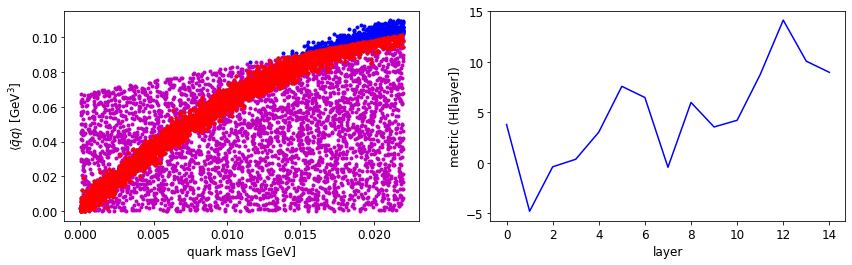

training epoch: 200,   loss: 0.19458843767642975
lambda: -9.54411506652832,   AdS radius: 0.9518320560455322[1/GeV]
[ 3.7804215  -4.80855    -0.40708098  0.34063897  3.02783     7.567118
  6.459265   -0.4510145   5.9719267   3.5419242   4.2040963   8.729499
 14.126667   10.05629     8.953533  ]


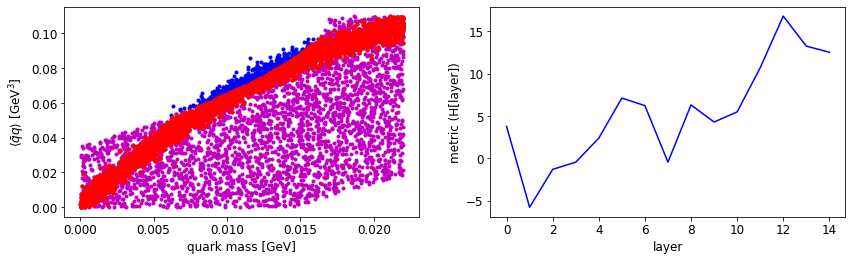

training epoch: 300,   loss: 0.1307535618543625
lambda: -13.384173393249512,   AdS radius: 1.5647375583648682[1/GeV]
[ 3.781273   -5.79775    -1.3185321  -0.46376997  2.378527    7.1210256
  6.225501   -0.46248788  6.309045    4.2859163   5.4825935  10.70555
 16.8195     13.268568   12.546483  ]


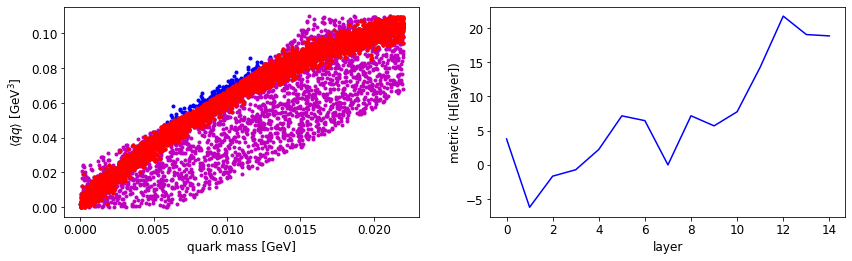

training epoch: 400,   loss: 0.06569080054759979
lambda: -10.214262008666992,   AdS radius: 1.5005427598953247[1/GeV]
[ 3.7832885e+00 -6.1930022e+00 -1.6514421e+00 -7.1460164e-01
  2.2472429e+00  7.1576052e+00  6.4568820e+00 -4.8803613e-03
  7.1682935e+00  5.6990795e+00  7.7572246e+00  1.4267848e+01
  2.1729828e+01  1.9040089e+01  1.8837757e+01]


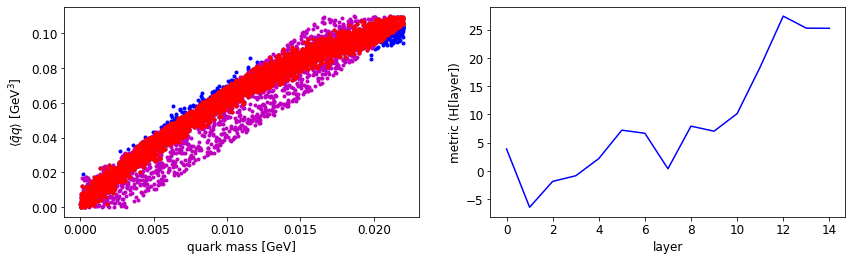

training epoch: 500,   loss: 0.022128380835056305
lambda: -6.4891743659973145,   AdS radius: 1.3196749687194824[1/GeV]
[ 3.89393   -6.4200597 -1.8400993 -0.851054   2.1903753  7.2196674
  6.6673145  0.391936   7.9312544  7.0417857 10.1487665 18.399675
 27.402103  25.271597  25.246914 ]


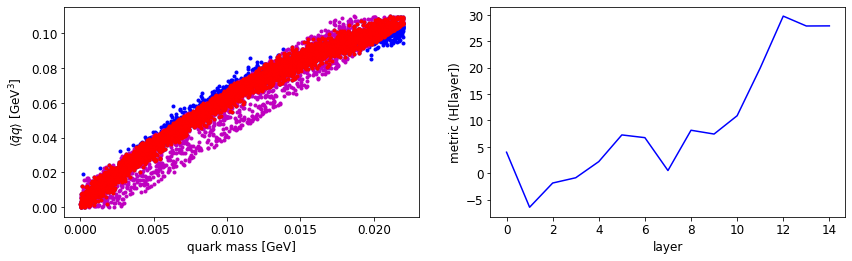

training epoch: 600,   loss: 0.017348788678646088
lambda: -2.1430201530456543,   AdS radius: 1.1708343029022217[1/GeV]
[ 3.9830441  -6.440757   -1.8524277  -0.85206485  2.2066662   7.2625155
  6.744677    0.5148305   8.1494055   7.4288707  10.898053   19.92992
 29.77423    27.903902   27.924196  ]


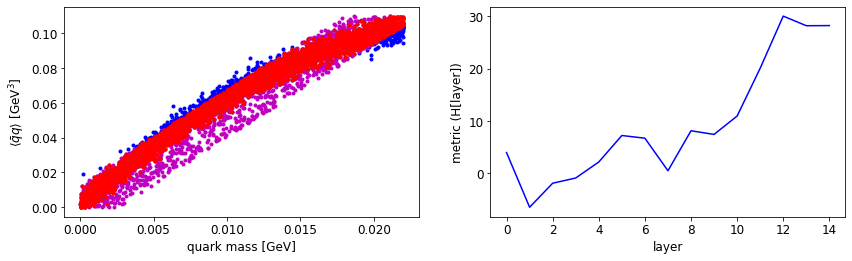

training epoch: 700,   loss: 0.016093650832772255
lambda: 2.7849433422088623,   AdS radius: 1.199457049369812[1/GeV]
[ 3.9893584 -6.4584737 -1.8694742 -0.8679425  2.1926823  7.2515526
  6.7377157  0.5132681  8.15918    7.4594617 10.974787  20.110922
 30.070175  28.23515   28.261652 ]


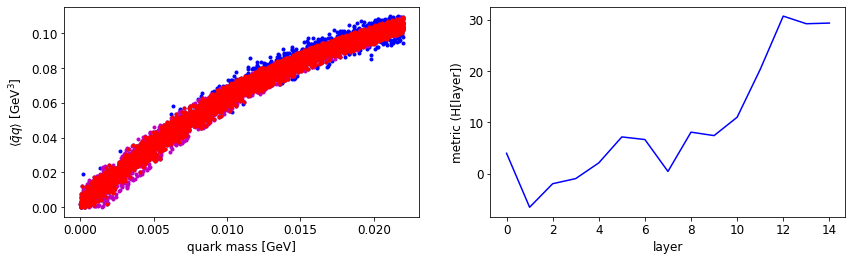

training epoch: 800,   loss: 0.007086190395057201
lambda: 6.394808769226074,   AdS radius: 1.6491039991378784[1/GeV]
[ 3.9440322  -6.5793376  -1.9918728  -0.9906779   2.070933    7.132378
  6.6224484   0.40383112  8.063794    7.390955   10.97003    20.290384
 30.689892   29.205385   29.331427  ]


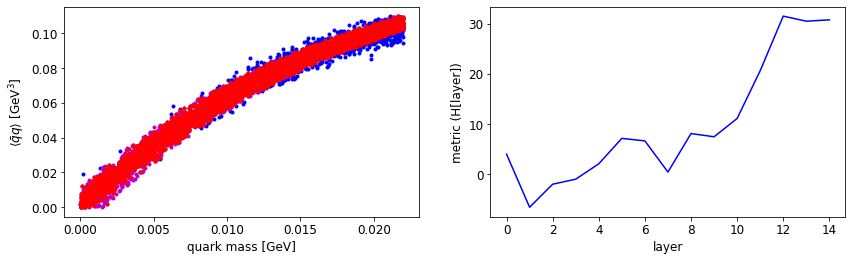

training epoch: 900,   loss: 0.007027937564998865
lambda: 6.357308864593506,   AdS radius: 1.6432197093963623[1/GeV]
[ 3.981908   -6.5934076  -2.0048053  -1.0018308   2.0625417   7.128305
  6.624119    0.41319594  8.089376    7.446329   11.0944805  20.609358
 31.48568    30.47224    30.743027  ]


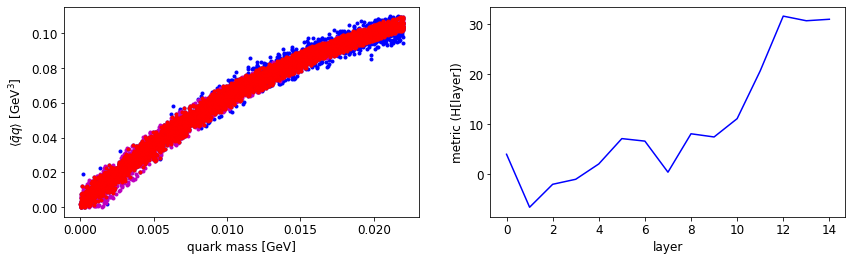

training epoch: 1000,   loss: 0.006849123165011406
lambda: 6.3967156410217285,   AdS radius: 1.6455734968185425[1/GeV]
[ 3.9942312 -6.5961003 -2.0073695 -1.0040789  2.0607667  7.1272526
  6.6240716  0.4144921  8.093251   7.4549565 11.114025  20.660042
 31.617031  30.69009   30.986721 ]


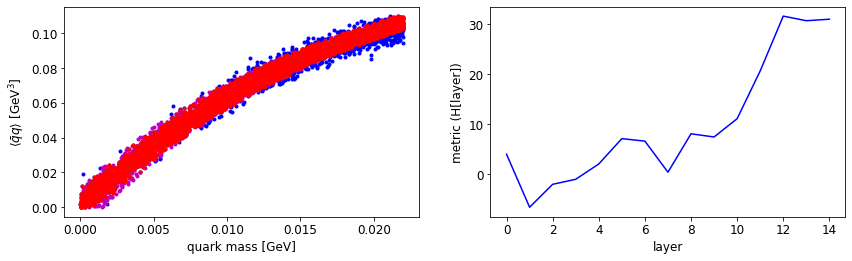

training epoch: 1100,   loss: 0.006674907635897398
lambda: 6.44323205947876,   AdS radius: 1.6439075469970703[1/GeV]
[ 3.9967163  -6.5981965  -2.0094786  -1.0060717   2.0589087   7.1255445
  6.622611    0.41339132  8.092515    7.454897   11.115407   20.664833
 31.630207   30.710676   31.009115  ]


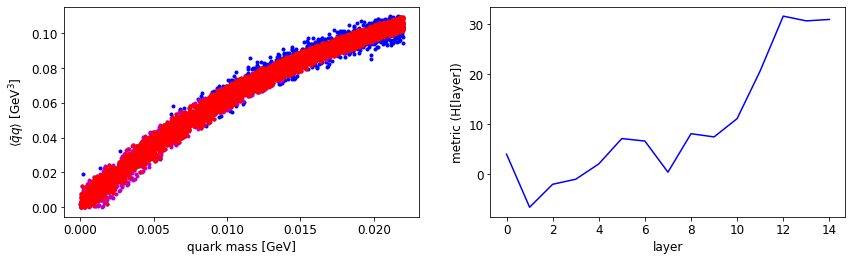

training epoch: 1200,   loss: 0.0064735691994428635
lambda: 6.4890594482421875,   AdS radius: 1.6402257680892944[1/GeV]
[ 4.0006604 -6.5955215 -2.006908  -1.0034754  2.0614638  7.127991
  6.624916   0.4155748  8.093992   7.454996  11.112095  20.651257
 31.588648  30.636227  30.922358 ]


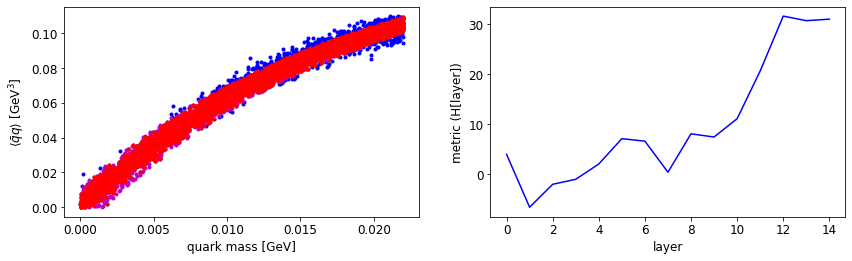

training epoch: 1300,   loss: 0.006670553237199783
lambda: 6.531955242156982,   AdS radius: 1.6408215761184692[1/GeV]
[ 4.0009394  -6.5955205  -2.0068789  -1.0032326   2.061988    7.128886
  6.6264334   0.41785473  8.097624    7.4610305  11.123583   20.678175
 31.65651    30.747093   31.043732  ]


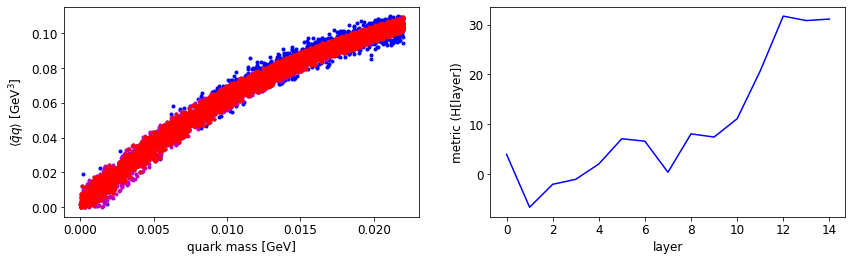

training epoch: 1400,   loss: 0.006722853984683752
lambda: 6.579594612121582,   AdS radius: 1.6417227983474731[1/GeV]
[ 4.0001087  -6.596631   -2.0080304  -1.0042503   2.0611236   7.128244
  6.626124    0.41803288  8.098479    7.4630427  11.1281185  20.689703
 31.685234   30.791725   31.091679  ]


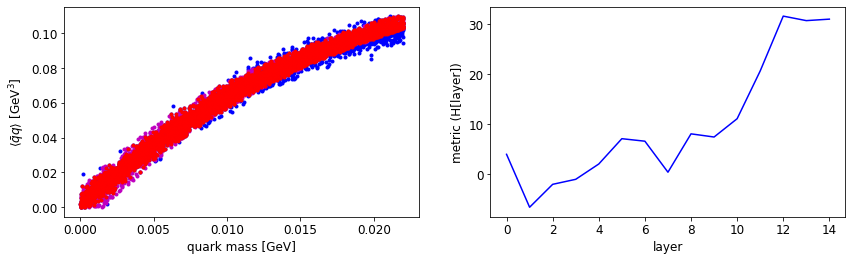

training epoch: 1500,   loss: 0.02250107377767563
lambda: 6.621888637542725,   AdS radius: 1.635495662689209[1/GeV]
[ 3.9967086  -6.598004   -2.0104814  -1.0062951   2.0590932   7.125695
  6.6238356   0.41679054  8.095709    7.4609056  11.124821   20.68168
 31.664103   30.762133   31.05707   ]


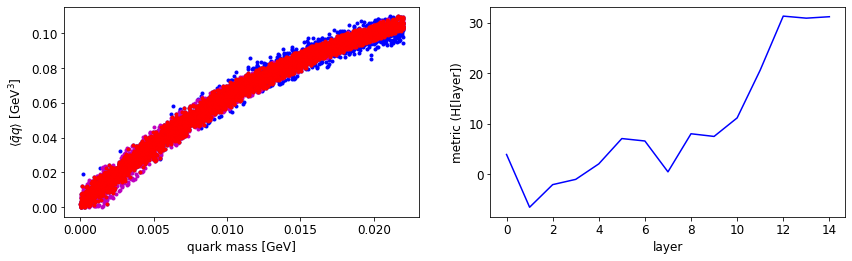

training epoch: 1600,   loss: 0.02198544703423977
lambda: 6.665921688079834,   AdS radius: 1.6341619491577148[1/GeV]
[ 3.9140522  -6.519104   -2.045909   -1.0048345   2.0567577   7.065434
  6.58306     0.48135605  8.014708    7.48636    11.148157   20.596073
 31.282076   30.877369   31.162657  ]


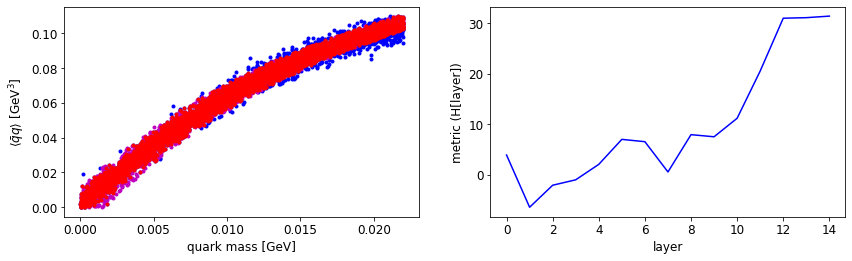

training epoch: 1700,   loss: 0.021501457318663597
lambda: 6.710178852081299,   AdS radius: 1.631328821182251[1/GeV]
[ 3.8896847 -6.44977   -2.0925026 -1.0147854  2.0430734  6.993805
  6.531591   0.5370939  7.9259152  7.5058484 11.171898  20.527073
 30.98713   31.095098  31.40229  ]


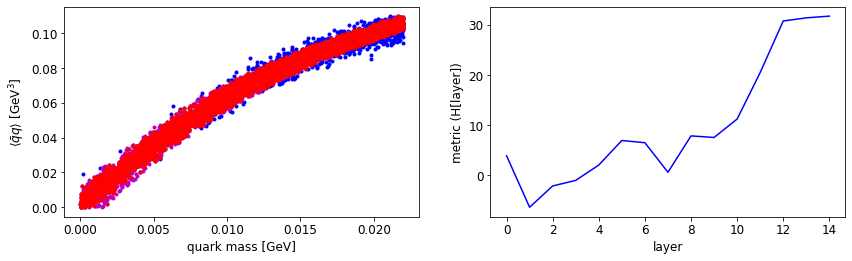

training epoch: 1800,   loss: 0.02106478437781334
lambda: 6.753273963928223,   AdS radius: 1.6304558515548706[1/GeV]
[ 3.8837733  -6.3830214  -2.1399171  -1.0270249   2.0271761   6.9215956
  6.479424    0.59027135  7.839421    7.5250273  11.198868   20.471062
 30.74575    31.367079   31.718     ]


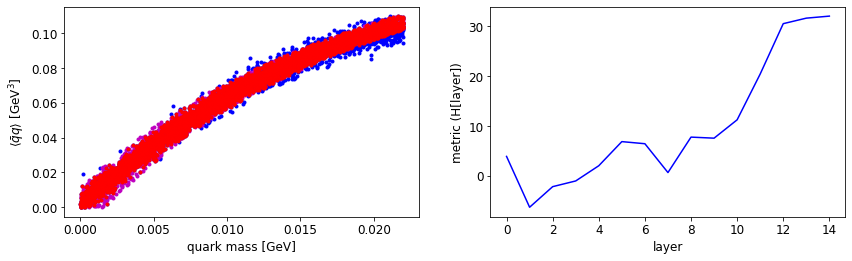

training epoch: 1900,   loss: 0.02099970541894436
lambda: 6.795706748962402,   AdS radius: 1.6281429529190063[1/GeV]
[ 3.8817732 -6.3181    -2.1875863 -1.0410107  2.009514   6.849038
  6.4264865  0.6405661  7.753972   7.541383  11.22304   20.412859
 30.516075  31.623049  32.03075  ]


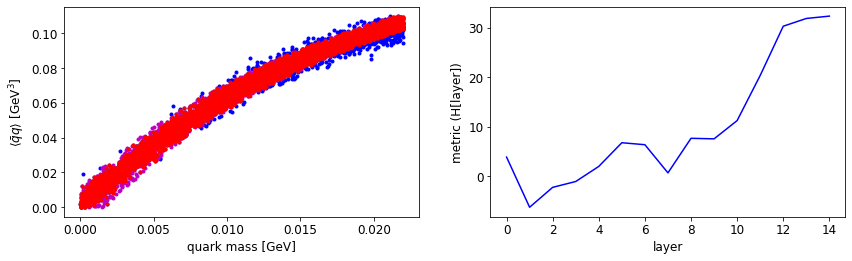

training epoch: 2000,   loss: 0.020634623244404793
lambda: 6.8361968994140625,   AdS radius: 1.6248584985733032[1/GeV]
[ 3.8823578  -6.2513123  -2.233739   -1.0543517   1.9924059   6.7774463
  6.3745356   0.69148654  7.6707225   7.557913   11.24769    20.355083
 30.302254   31.86786    32.3428    ]


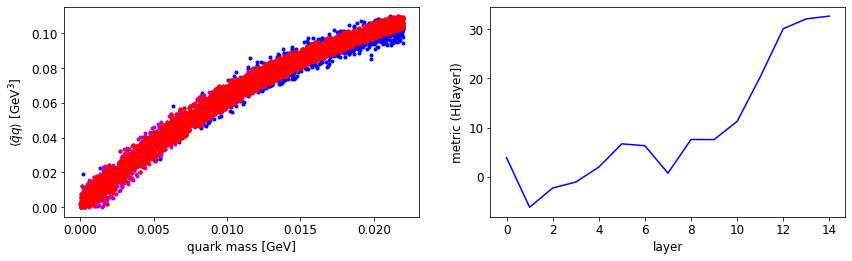

training epoch: 2100,   loss: 0.02061554044485092
lambda: 6.876155853271484,   AdS radius: 1.6218373775482178[1/GeV]
[ 3.8820477 -6.1860504 -2.279784  -1.0690012  1.9739902  6.7060246
  6.3224187  0.7402618  7.5894995  7.5732636 11.272386  20.302113
 30.115582  32.123856  32.680878 ]


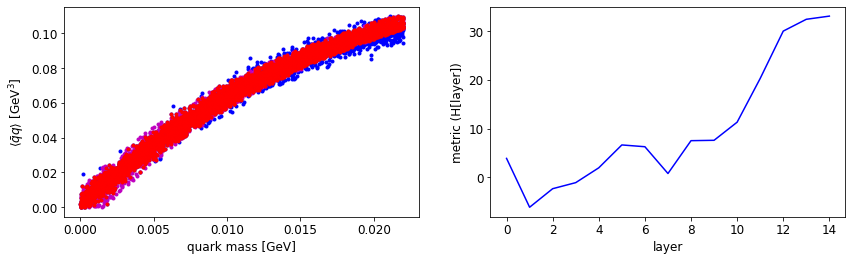

training epoch: 2200,   loss: 0.020336298272013664
lambda: 6.917501449584961,   AdS radius: 1.6211388111114502[1/GeV]
[ 3.8828282 -6.120911  -2.3233204 -1.082821   1.9564157  6.637289
  6.2725086  0.7882029  7.512466   7.5885177 11.297347  20.252705
 29.950266  32.36895   33.01955  ]


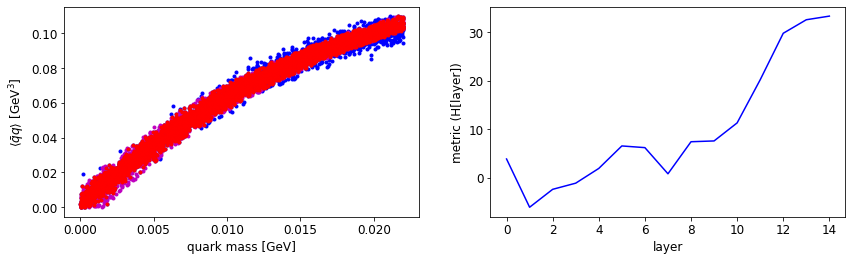

training epoch: 2300,   loss: 0.020240265876054764
lambda: 6.961796283721924,   AdS radius: 1.6206750869750977[1/GeV]
[ 3.8849688 -6.055021  -2.3644412 -1.0956421  1.9397562  6.5707526
  6.224215   0.835478   7.4381385  7.602276  11.31909   20.197025
 29.778399  32.56528   33.31295  ]


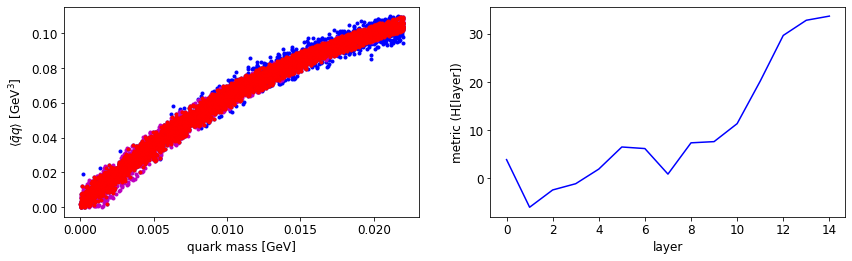

training epoch: 2400,   loss: 0.019663261249661446
lambda: 7.007633209228516,   AdS radius: 1.6217423677444458[1/GeV]
[ 3.8859694 -5.990097  -2.4055386 -1.1095759  1.9219892  6.5041976
  6.1757965  0.8812871  7.365513   7.6156335 11.342088  20.148191
 29.633417  32.78169   33.63889  ]


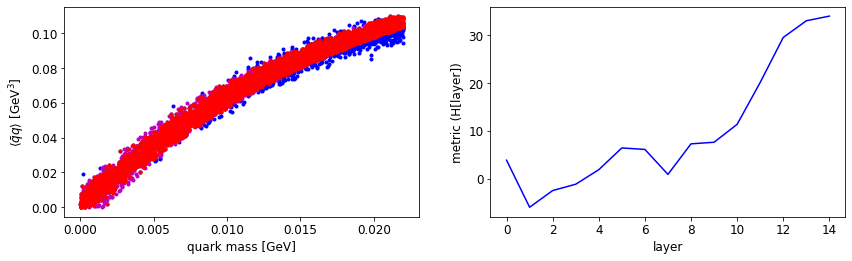

training epoch: 2500,   loss: 0.019550971686840057
lambda: 7.040027618408203,   AdS radius: 1.6129411458969116[1/GeV]
[ 3.8849535 -5.927355  -2.4473805 -1.1255107  1.9021379  6.4366174
  6.1259565  0.9236118  7.292259   7.6245317 11.3588085 20.089495
 29.474237  32.951725  33.923565 ]


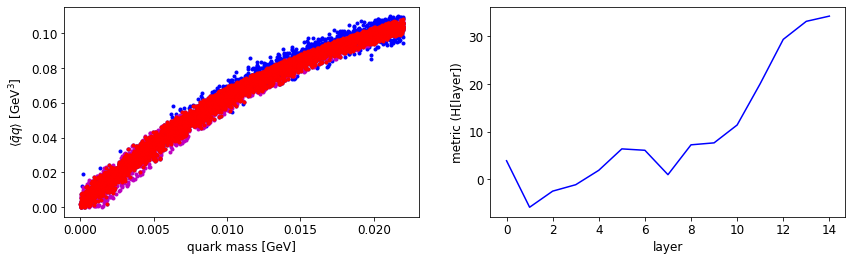

training epoch: 2600,   loss: 0.019289828836917877
lambda: 7.089627742767334,   AdS radius: 1.617474913597107[1/GeV]
[ 3.8902984 -5.8586555 -2.4814126 -1.134976   1.8887389  6.376885
  6.083538   0.9711527  7.22803    7.63931   11.381665  20.040075
 29.33471   33.11904   34.212364 ]


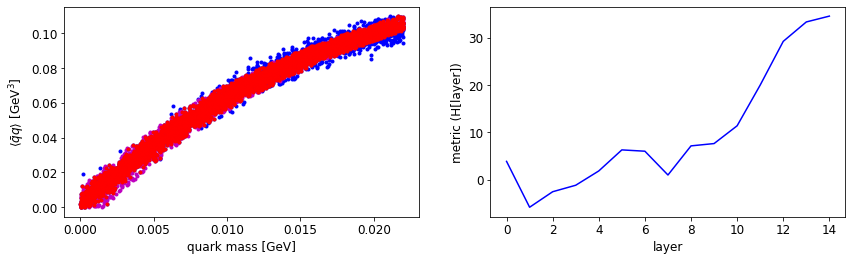

training epoch: 2700,   loss: 0.019154364243149757
lambda: 7.122649669647217,   AdS radius: 1.6111068725585938[1/GeV]
[ 3.8887591 -5.797259  -2.5214872 -1.15152    1.8683167  6.311281
  6.035214   1.0115013  7.1599903  7.6487556 11.401791  19.996502
 29.227543  33.328484  34.55917  ]


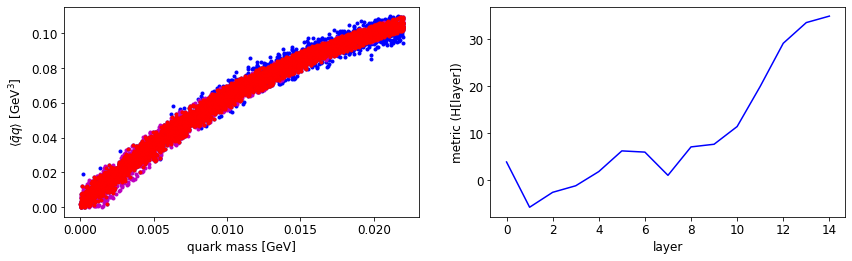

training epoch: 2800,   loss: 0.01891222782433033
lambda: 7.163050174713135,   AdS radius: 1.6104538440704346[1/GeV]
[ 3.8895397 -5.733269  -2.5583057 -1.1658069  1.8500757  6.2486377
  5.9896374  1.0534761  7.095688   7.6598296 11.423536  19.955374
 29.127234  33.531536  34.904755 ]


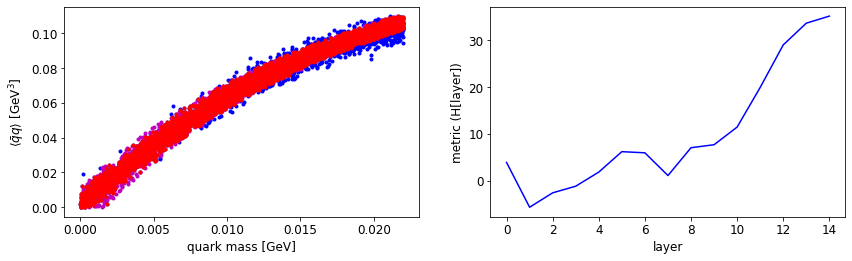

training epoch: 2900,   loss: 0.01863281801342964
lambda: 7.212320804595947,   AdS radius: 1.6091004610061646[1/GeV]
[ 3.8884256 -5.6707363 -2.5963762 -1.182388   1.8292226  6.183627
  5.9411006  1.0909963  7.027419   7.66239   11.430727  19.883831
 28.959835  33.594604  35.098064 ]


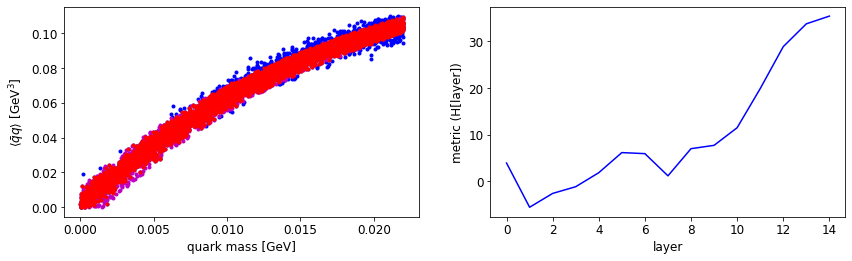

training epoch: 3000,   loss: 0.124445840716362
lambda: 7.250281810760498,   AdS radius: 1.6068484783172607[1/GeV]
[ 3.8804128 -5.5955024 -2.6296818 -1.1933222  1.8137065  6.1210895
  5.896591   1.1391875  6.963661   7.674709  11.451244  19.82947
 28.831095  33.72747   35.382256 ]


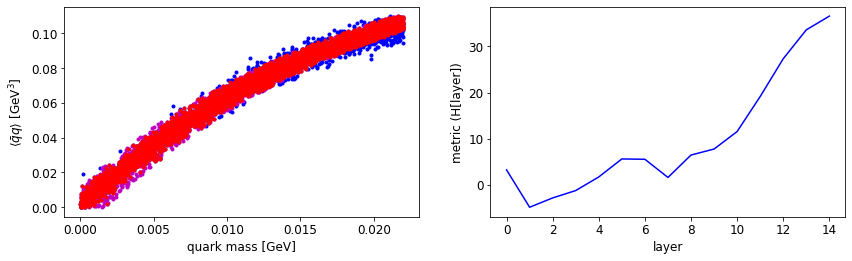

training epoch: 3100,   loss: 0.09914152324199677
lambda: 7.265005111694336,   AdS radius: 1.5964409112930298[1/GeV]
[ 3.2385786 -4.861786  -2.8402638 -1.24584    1.710387   5.605509
  5.538317   1.5958819  6.452626   7.755258  11.546656  19.136261
 27.32709   33.59041   36.564316 ]


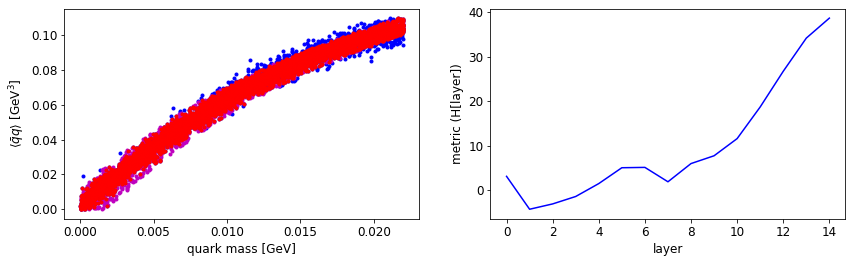

training epoch: 3200,   loss: 0.0850488469004631
lambda: 7.261873245239258,   AdS radius: 1.5919897556304932[1/GeV]
[ 3.150568  -4.2387323 -3.041726  -1.3740896  1.5246427  5.078891
  5.1578975  1.9270489  6.0160084  7.765809  11.618709  18.721487
 26.732662  34.178802  38.66807  ]


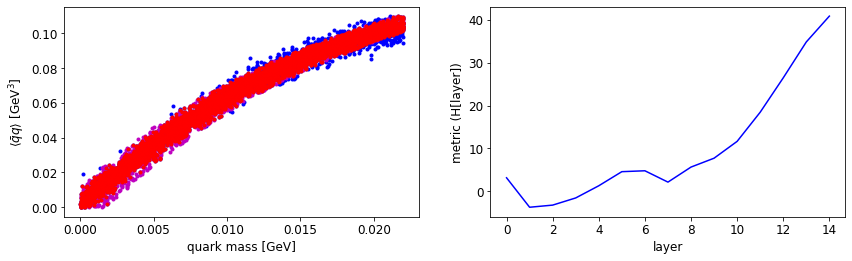

training epoch: 3300,   loss: 0.07439194619655609
lambda: 7.243661880493164,   AdS radius: 1.58607017993927[1/GeV]
[ 3.1791937 -3.6824834 -3.1863008 -1.5157707  1.3196101  4.6015286
  4.8097267  2.1699882  5.672498   7.738739  11.658232  18.444386
 26.449883  34.81052   40.824757 ]


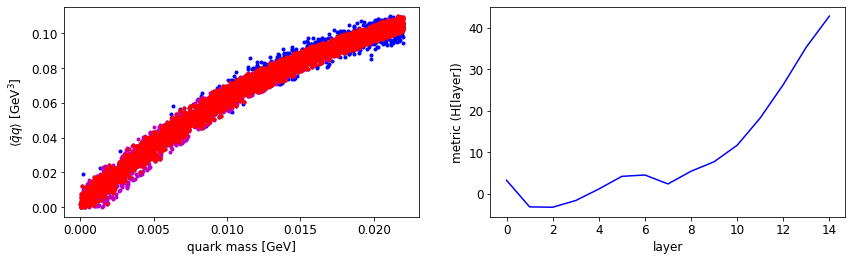

training epoch: 3400,   loss: 0.06652937084436417
lambda: 7.2242231369018555,   AdS radius: 1.582986831665039[1/GeV]
[ 3.2292113 -3.180105  -3.270691  -1.6487228  1.1183681  4.182487
  4.503932   2.3513691  5.407971   7.695244  11.67481   18.250235
 26.300423  35.35892   42.829258 ]


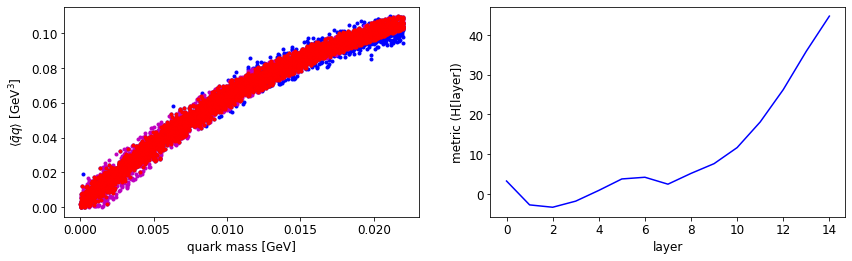

training epoch: 3500,   loss: 0.059703029692173004
lambda: 7.182337284088135,   AdS radius: 1.5738104581832886[1/GeV]
[ 3.2784414 -2.7179337 -3.3083093 -1.7737105  0.9187134  3.8015401
  4.22566    2.4889853  5.195715   7.6431317 11.678677  18.114408
 26.241545  35.88796   44.713436 ]


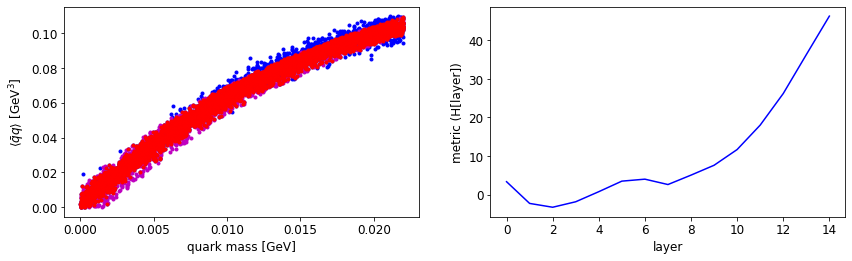

training epoch: 3600,   loss: 0.05460624396800995
lambda: 7.151822090148926,   AdS radius: 1.572623610496521[1/GeV]
[ 3.327518  -2.307161  -3.3012025 -1.8778683  0.7371574  3.4731567
  3.9866264  2.592447   5.034449   7.5923467 11.673666  18.01502
 26.207735  36.3004    46.302372 ]


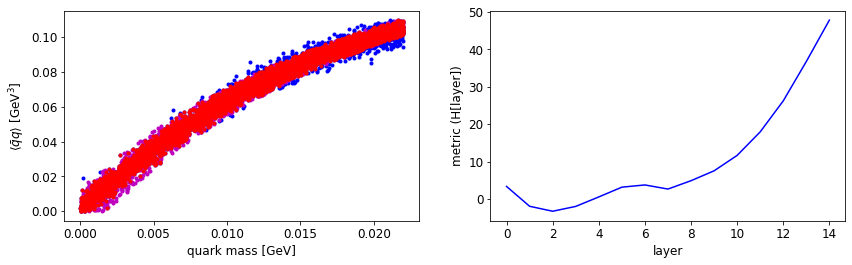

training epoch: 3700,   loss: 0.05024608224630356
lambda: 7.107336044311523,   AdS radius: 1.5689632892608643[1/GeV]
[ 3.365836   -1.9416689  -3.270092   -1.9766177   0.55641395  3.167439
  3.7622912   2.6637986   4.898365    7.5377827  11.663237   17.952568
 26.242992   36.766262   47.843906  ]


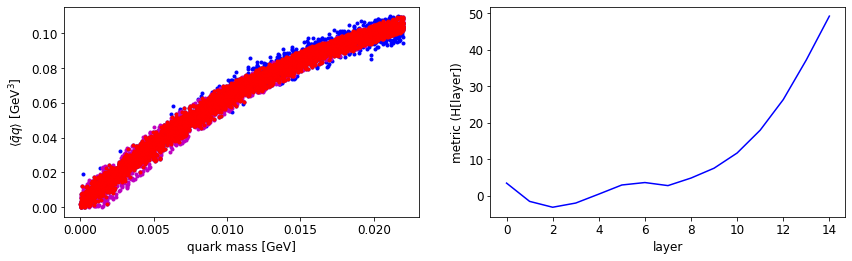

training epoch: 3800,   loss: 0.046599969267845154
lambda: 7.054584980010986,   AdS radius: 1.5646576881408691[1/GeV]
[ 3.4049916 -1.6047262 -3.2089632 -2.0594118  0.3864013  2.8883317
  3.557867   2.7184284  4.788374   7.4871078 11.650741  17.907072
 26.280684  37.14822   49.15394  ]


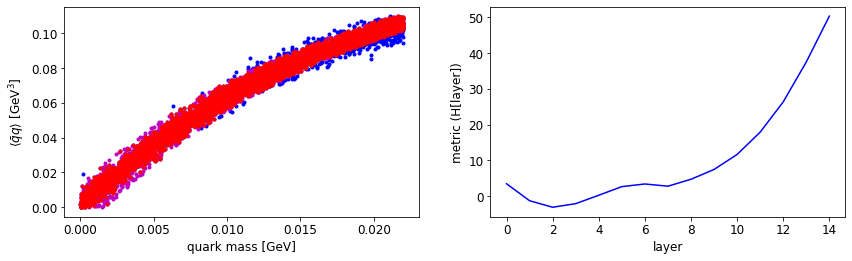

training epoch: 3900,   loss: 0.04391198977828026
lambda: 7.005970478057861,   AdS radius: 1.5631331205368042[1/GeV]
[ 3.4350543  -1.3157415  -3.1347215  -2.1315255   0.22649108  2.6360393
  3.3714287   2.7509003   4.696526    7.4374423  11.63487    17.87796
 26.336966   37.513874   50.328934  ]


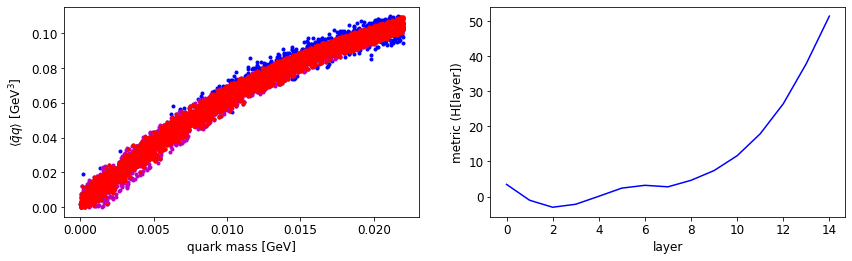

training epoch: 4000,   loss: 0.04147345572710037
lambda: 6.946063041687012,   AdS radius: 1.5599220991134644[1/GeV]
[ 3.4676132  -1.0495057  -3.0399776  -2.1870375   0.07981853  2.406698
  3.2024097   2.7754908   4.6234236   7.395077   11.621883   17.860083
 26.394396   37.836212   51.363194  ]


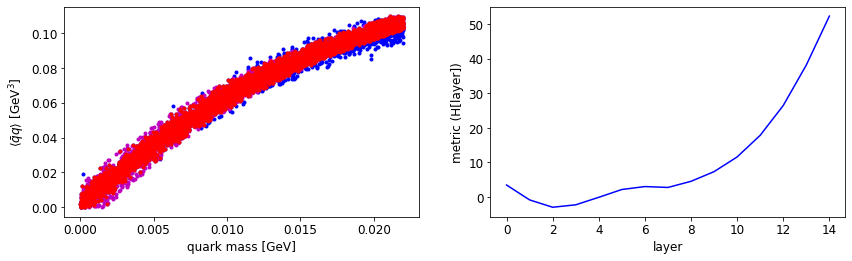

training epoch: 4100,   loss: 0.03945762664079666
lambda: 6.881045341491699,   AdS radius: 1.5565972328186035[1/GeV]
[ 3.489953   -0.8188     -2.9422445  -2.2386699  -0.06459156  2.18834
  3.0389714   2.7825632   4.556079    7.351389   11.607121   17.856176
 26.480476   38.179638   52.331833  ]


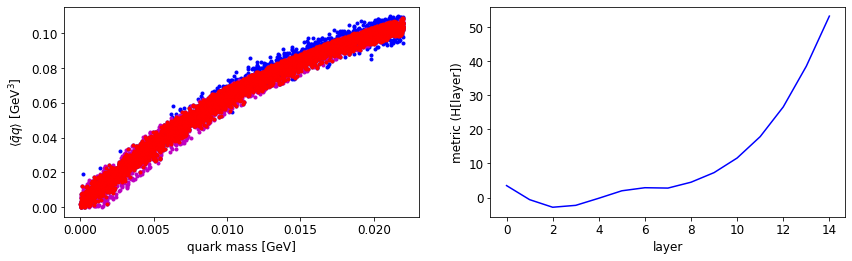

training epoch: 4200,   loss: 0.03773324191570282
lambda: 6.8167314529418945,   AdS radius: 1.5575366020202637[1/GeV]
[ 3.5175273  -0.6037929  -2.8288417  -2.272321   -0.19272232  1.9926425
  2.8933516   2.7886703   4.5055566   7.3185368  11.600115   17.86442
 26.570604   38.493484   53.18477   ]


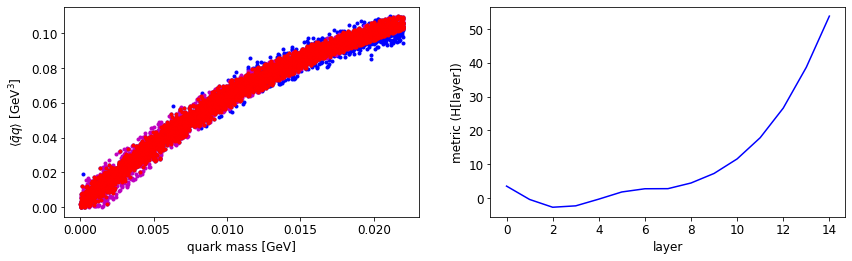

training epoch: 4300,   loss: 0.03695020079612732
lambda: 6.756816387176514,   AdS radius: 1.5518300533294678[1/GeV]
[ 3.5351985 -0.4176158 -2.718199  -2.3043907 -0.3202977  1.8025057
  2.7484517  2.7787054  4.4527082  7.2775235 11.578832  17.85185
 26.605448  38.676952  53.814236 ]


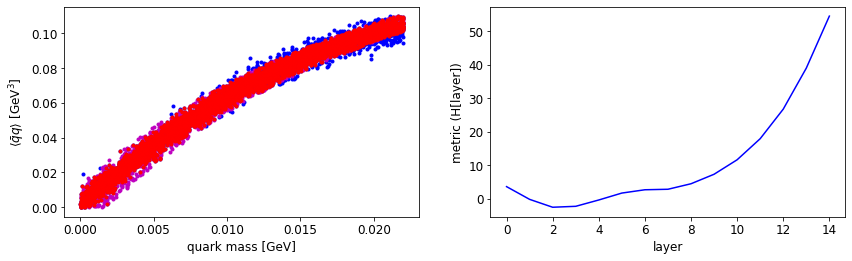

training epoch: 4400,   loss: 0.034786488860845566
lambda: 6.686858177185059,   AdS radius: 1.5493801832199097[1/GeV]
[ 3.554914   -0.247792   -2.6019533  -2.3234832  -0.43399075  1.6312886
  2.6181636   2.7684493   4.4125433   7.2480106  11.570895   17.86572
 26.692804   38.94277    54.469337  ]


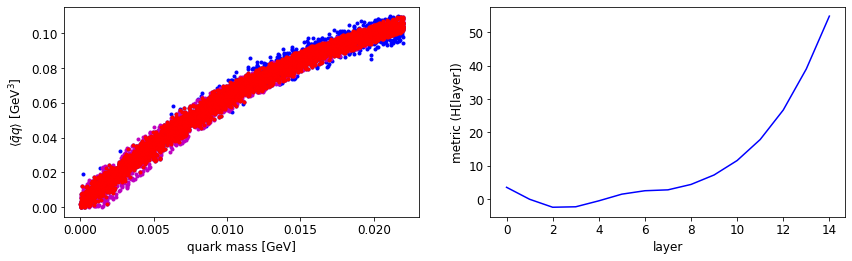

training epoch: 4500,   loss: 0.25518569350242615
lambda: 6.615506172180176,   AdS radius: 1.550112247467041[1/GeV]
[ 3.5221395  -0.07437092 -2.4678798  -2.330329   -0.54450524  1.461159
  2.4881077   2.7556407   4.3764963   7.2189355  11.557913   17.862854
 26.716988   39.050835   54.91629   ]


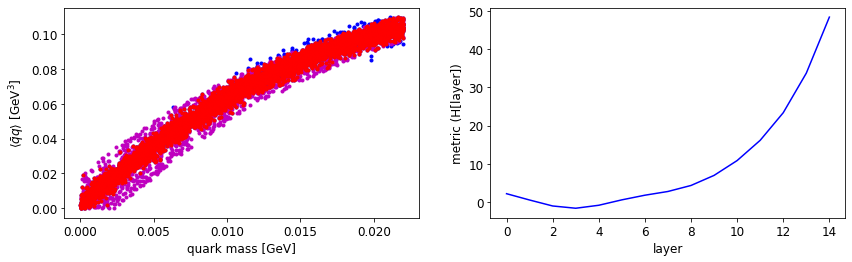

training epoch: 4600,   loss: 0.1420150101184845
lambda: 6.157149791717529,   AdS radius: 1.572481632232666[1/GeV]
[ 2.1039078  0.4451514 -1.1201512 -1.7154636 -0.9324304  0.4882134
  1.7075163  2.6886513  4.2660704  6.9110703 10.806441  16.124094
 23.370989  33.760036  48.475853 ]


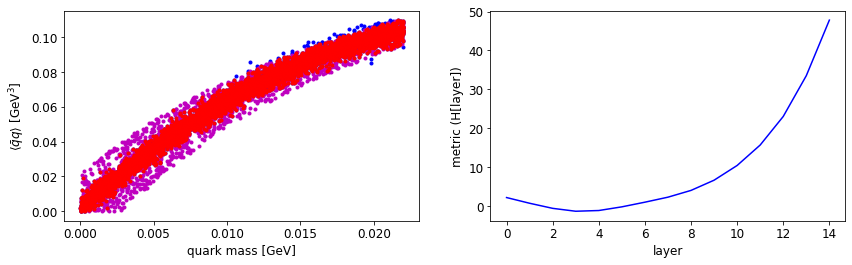

training epoch: 4700,   loss: 0.12480395287275314
lambda: 5.172430515289307,   AdS radius: 1.6121174097061157[1/GeV]
[ 2.2073877   0.74132854 -0.5666675  -1.3112098  -1.1242121  -0.18200663
  1.0153997   2.3034132   4.0421886   6.662881   10.446238   15.700547
 23.04112    33.516933   47.78911   ]


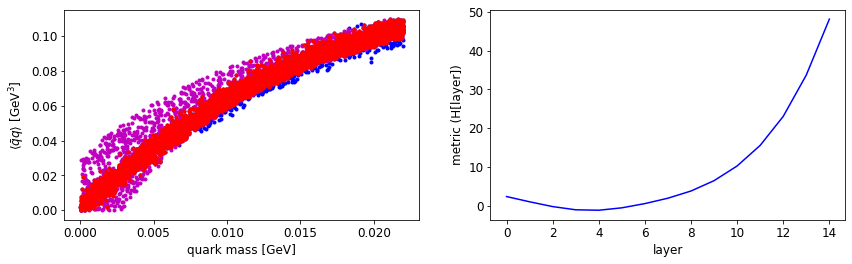

training epoch: 4800,   loss: 0.11544220894575119
lambda: 4.2495598793029785,   AdS radius: 1.711531162261963[1/GeV]
[ 2.33752     0.98298264 -0.25550136 -1.0847584  -1.1998076  -0.5743922
  0.51964796  1.9115319   3.772579    6.4414787  10.242129   15.564732
 23.057514   33.743584   48.18584   ]


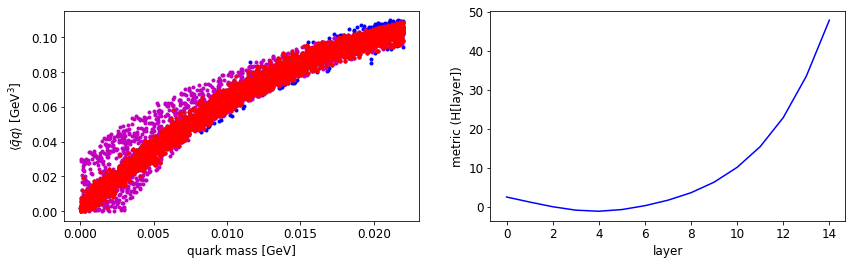

training epoch: 4900,   loss: 0.11058997362852097
lambda: 3.592360019683838,   AdS radius: 1.758176326751709[1/GeV]
[ 2.4475775e+00  1.1638722e+00 -4.1111156e-02 -9.2157489e-01
 -1.1998836e+00 -7.6984817e-01  2.2234158e-01  1.6316137e+00
  3.5509565e+00  6.2536664e+00  1.0059278e+01  1.5365949e+01
  2.2808296e+01  3.3416988e+01  4.7808224e+01]


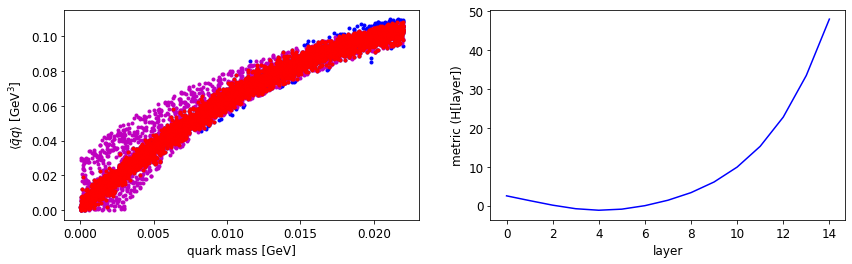

training epoch: 5000,   loss: 0.10735085606575012
lambda: 2.901770830154419,   AdS radius: 1.8006783723831177[1/GeV]
[ 2.5270600e+00  1.3006043e+00  1.2475250e-01 -7.8883737e-01
 -1.1809838e+00 -8.9945841e-01 -2.9237662e-03  1.3971694e+00
  3.3536901e+00  6.0936904e+00  9.9291391e+00  1.5276468e+01
  2.2795382e+01  3.3519806e+01  4.8026505e+01]


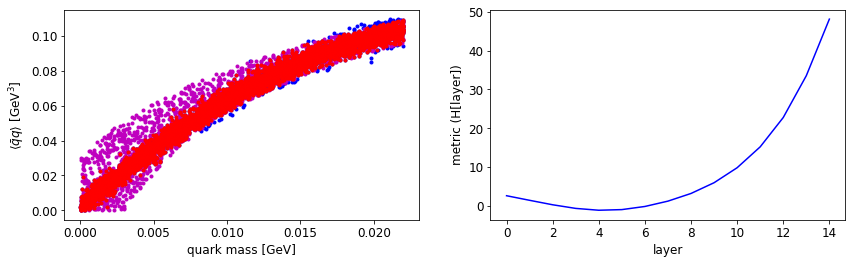

training epoch: 5100,   loss: 0.10433857887983322
lambda: 2.2357935905456543,   AdS radius: 1.855615258216858[1/GeV]
[ 2.5882847   1.4070894   0.2560829  -0.67854625 -1.1535354  -0.98894507
 -0.17994799  1.1961626   3.1722934   5.942049    9.806301   15.187738
 22.749966   33.528767   48.11774   ]


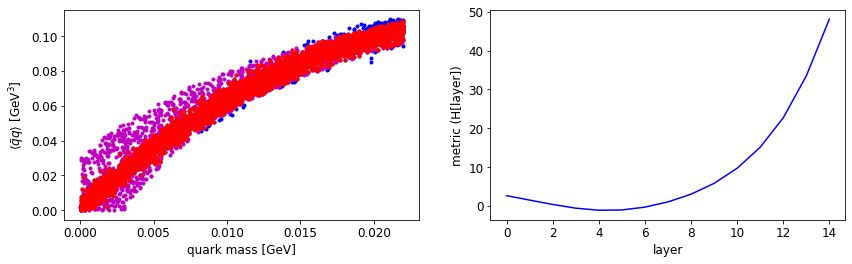

training epoch: 5200,   loss: 0.10173477977514267
lambda: 1.587007999420166,   AdS radius: 1.9322450160980225[1/GeV]
[ 2.6385503   1.493753    0.36400023 -0.58385956 -1.120501   -1.0494143
 -0.31871706  1.0262455   3.0099657   5.8017774   9.690259   15.096603
 22.681362   33.477913   48.102673  ]


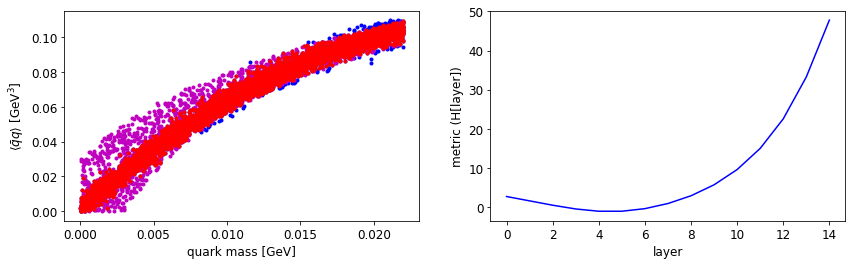

training epoch: 5300,   loss: 0.09898126870393753
lambda: 1.011322259902954,   AdS radius: 2.041050434112549[1/GeV]
[ 2.6774976   1.5615143   0.4491131  -0.50699925 -1.0890187  -1.0910562
 -0.42729032  0.8843227   2.8662152   5.66986     9.569769   14.975692
 22.528612   33.24676    47.782692  ]


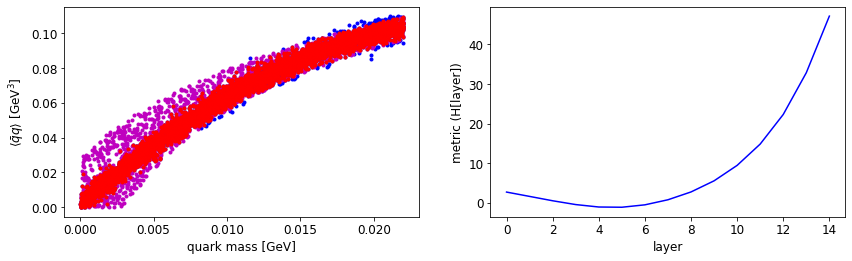

training epoch: 5400,   loss: 0.09649930894374847
lambda: 0.5448035001754761,   AdS radius: 2.193028211593628[1/GeV]
[ 2.7101386  1.6168498  0.5182958 -0.4430957 -1.0586134 -1.1172587
 -0.509013   0.7703907  2.7442834  5.550506   9.448427  14.828968
 22.300417  32.837944  47.126076 ]


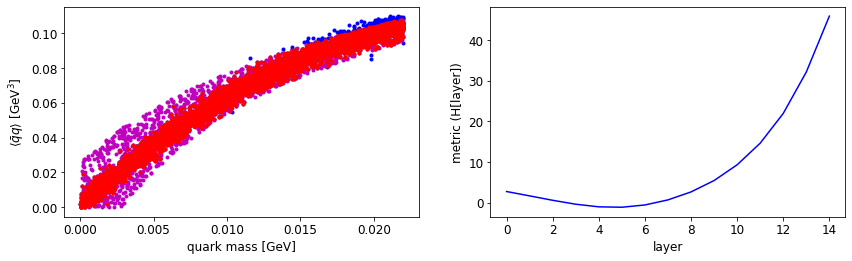

training epoch: 5500,   loss: 0.09322656691074371
lambda: 0.23725980520248413,   AdS radius: 2.4190051555633545[1/GeV]
[ 2.738931    1.6641123   0.5765285  -0.38875416 -1.0300771  -1.13368
 -0.57203776  0.67682374  2.637997    5.4377275   9.318132   14.642154
 21.962053   32.16185    45.926598  ]


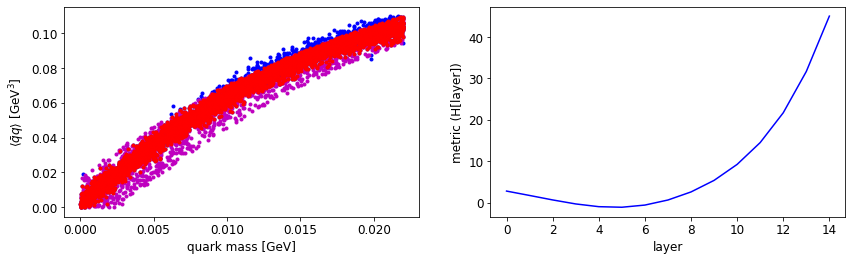

training epoch: 5600,   loss: 0.09035816043615341
lambda: 0.04986527934670448,   AdS radius: 2.737639904022217[1/GeV]
[ 2.7638924   1.7047515   0.6260524  -0.341756   -1.0020484  -1.1395426
 -0.6143849   0.60885906  2.5573504   5.348535    9.20984    14.480551
 21.677444   31.65394    45.02629   ]


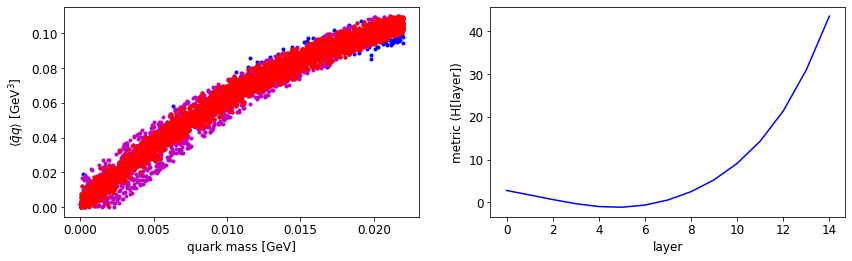

training epoch: 5700,   loss: 0.08723891526460648
lambda: 0.019262563437223434,   AdS radius: 3.0414953231811523[1/GeV]
[ 2.7765536   1.7278799   0.65564275 -0.31378636 -0.9870951  -1.1481979
 -0.64931107  0.5539684   2.4901314   5.26951     9.105945   14.313904
 21.360458   30.979208   43.56716   ]


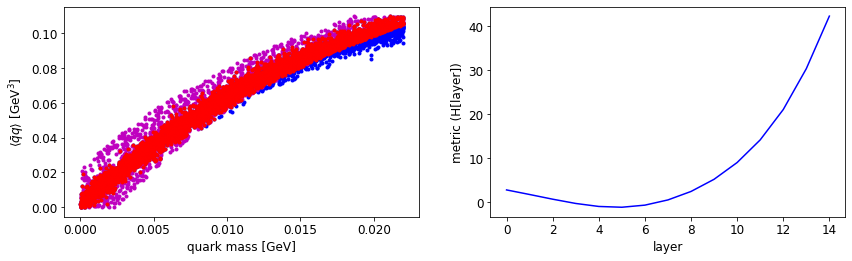

training epoch: 5800,   loss: 0.08686678111553192
lambda: 0.014785039238631725,   AdS radius: 3.2193634510040283[1/GeV]
[ 2.785838    1.745352    0.678225   -0.29213178 -0.9750516  -1.153983
 -0.67543364  0.5116739   2.4368112   5.2044687   9.016718   14.165615
 21.071022   30.365753   42.324482  ]


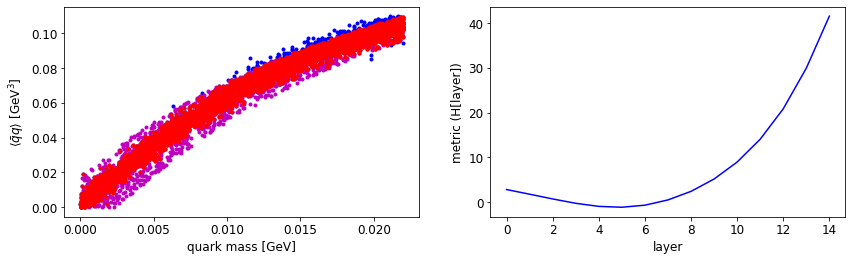

training epoch: 5900,   loss: 0.0859958678483963
lambda: 0.011566093191504478,   AdS radius: 3.353494644165039[1/GeV]
[ 2.7979968   1.7645862   0.7020218  -0.26880357 -0.959478   -1.1531415
 -0.69168323  0.48158267  2.397088    5.1545744   8.946326   14.046567
 20.84277    29.923347   41.55742   ]


In [20]:
total_epoch=6000
show_epoch_each=100

for epoch in range(total_epoch):
    if epoch==0:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==1500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==3000:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==4500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
print(c_reg1)

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)